In [ ]:
# pyright: reportUnusedExpression=false

In [ ]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [ ]:
from numpy.typing import NDArray

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
@jit(nopython=True)
def vizinhos(N: int):
    # Define a tabela de vizinhos
    L = int(np.sqrt(N))
    viz = np.zeros((N, 4), dtype=np.int16)
    for k in range(N):
        viz[k, 0] = k + 1
        if (k + 1) % L == 0:
            viz[k, 0] = k + 1 - L
        viz[k, 1] = k + L
        if k > (N - L - 1):
            viz[k, 1] = k + L - N
        viz[k, 2] = k - 1
        if k % L == 0:
            viz[k, 2] = k + L - 1
        viz[k, 3] = k - L
        if k < L:
            viz[k, 3] = k + N - L
    return viz

In [ ]:
@jit(nopython=True)
def algoritmo_de_metropolis(L: int, T: float, passos: int):
    energia: np.ndarray = np.zeros(passos, dtype=np.int32)
    magnetização: np.ndarray = np.zeros(passos, dtype=np.int32)

    spins: np.ndarray = np.array([-1, 1], dtype=np.int8)

    variações_de_energia = np.array([8.0, 4.0, 0.0, -4.0, -8.0], dtype=np.float64)
    expoentes = np.exp(variações_de_energia / T)

    N = L * L
    S = np.random.choice(spins, N)

    viz = vizinhos(N)

    for i in range(passos):
        for k in np.arange(N):
            índice = int(S[k] * np.sum(S[viz[k]]) * 0.5 + 2)
            if np.random.rand() < expoentes[índice]:
                S[k] = -1 * S[k]
        energia[i] = -np.sum(S * (S[viz[:, 0]] + S[viz[:, 1]]))
        magnetização[i] = np.sum(S)

    return energia, magnetização

In [ ]:
@jit(nopython=True)
def calor_específico(T: float, N: int, E: NDArray) -> NDArray:
    return (np.average(np.power(E, 2)) - np.power(np.average(E), 2)) / (
        N * np.power(T, 2)
    )

In [ ]:
@jit(nopython=True)
def suscetibilidade_magnética(T: float, N: int, M: NDArray) -> NDArray:
    return (np.average(np.power(M, 2)) - np.power(np.average(M), 2)) / (N * T)

In [ ]:
@jit(nopython=True)
def calcula_erro(arr: NDArray) -> float:
    return np.sqrt(
        np.sum(np.power(arr - np.average(arr), 2)) / (arr.size * (arr.size - 1))
    )

In [ ]:
# TODO: tentar botar numba
def calcula_métricas(
    passo: int,
    seguro: int,
    passosDeMC: int,
    temperatura: float,
    numSpins: int,
    energias: NDArray[np.float64],
    magnetizações: NDArray[np.float64],
):
    magnetizações_mod = np.abs(magnetizações)
    energias_att: np.ndarray = np.array([energia[seguro:] for energia in energias])
    magnetizações_att = np.array(
        [magnetização[seguro:] for magnetização in magnetizações_mod]
    )
    batches = int((passosDeMC - seguro) / passo)
    tensor = np.zeros((N, batches, 4))
    for i in range(N):
        for j in range(0, passosDeMC - seguro, passo):
            cal = calor_específico(
                temperatura, numSpins, energias_att[i][j : j + passo]
            )
            sus = suscetibilidade_magnética(
                temperatura, numSpins, magnetizações_att[i][j : j + passo]
            )
            ene = np.average(energias_att[i][j : j + passo]) / numSpins
            mag = np.average(magnetizações_att[i][j : j + passo]) / numSpins
            tensor[i][int(j / passo)] = np.array([cal, sus, ene, mag])

    erros = np.zeros((N, 4))
    for i, matrix in enumerate(tensor):
        erro_cal = calcula_erro(matrix[:, 0])
        erro_sus = calcula_erro(matrix[:, 1])
        erro_ene = calcula_erro(matrix[:, 2])
        erro_mag = calcula_erro(matrix[:, 3])
        erros[i] = np.array([erro_cal, erro_sus, erro_ene, erro_mag])

    novas = [np.average(matrix, axis=0) for matrix in tensor]

    return novas, erros

In [ ]:
N = 1
PARTIÇÃO = 1000
temperaturas = np.linspace(0.4, 3, 20)
comprimentos = np.linspace(32, 100, 5, dtype=int)
NÚMERO_DE_SEGURANÇA = 5000
PASSOS_DE_MONTECARLO = 15000
energias = np.zeros((N, PASSOS_DE_MONTECARLO))
magnetizações = np.zeros((N, PASSOS_DE_MONTECARLO))
temperaturas = np.linspace(0.4, 3, 20)
métricas = np.zeros((temperaturas.size, N, 4), dtype=np.float64)
erros = np.zeros((temperaturas.size, 4), dtype=np.float64)

In [ ]:
def plot_por_comprimento(comprimento: int):
    NÚMERO_DE_SPINS = np.power(comprimento, 2)
    for i, t in enumerate(temperaturas):
        for j in range(N):
            energias[j], magnetizações[j] = algoritmo_de_metropolis(
                comprimento, t, PASSOS_DE_MONTECARLO
            )
        métricas[i], erros[i] = calcula_métricas(
            PARTIÇÃO,
            NÚMERO_DE_SEGURANÇA,
            PASSOS_DE_MONTECARLO,
            t,
            NÚMERO_DE_SPINS,
            energias,
            magnetizações,
        )
    titulos = [
        "Calor Específico",
        "Suscetibilidade Magnética",
        "Energias",
        "Magnetizações",
    ]
    fig = plt.figure(figsize=(10, 20))
    gs = gridspec.GridSpec(4, 1, figure=fig)
    for i in range(4):
        ax = fig.add_subplot(gs[i])
        ax.set_title(f"{titulos[i]} {comprimento}")
        ax.set_ylabel(titulos[i])
        ax.set_xlabel("Temperatura")
        ax.errorbar(
            x=temperaturas,
            y=métricas[:, 0][:, i],
            yerr=erros[:, i],
            fmt="o",
            markersize=1,
            ecolor="red",
            color="blue",
        )

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.savefig(f"{comprimento}-métricas.png")
    plt.show()

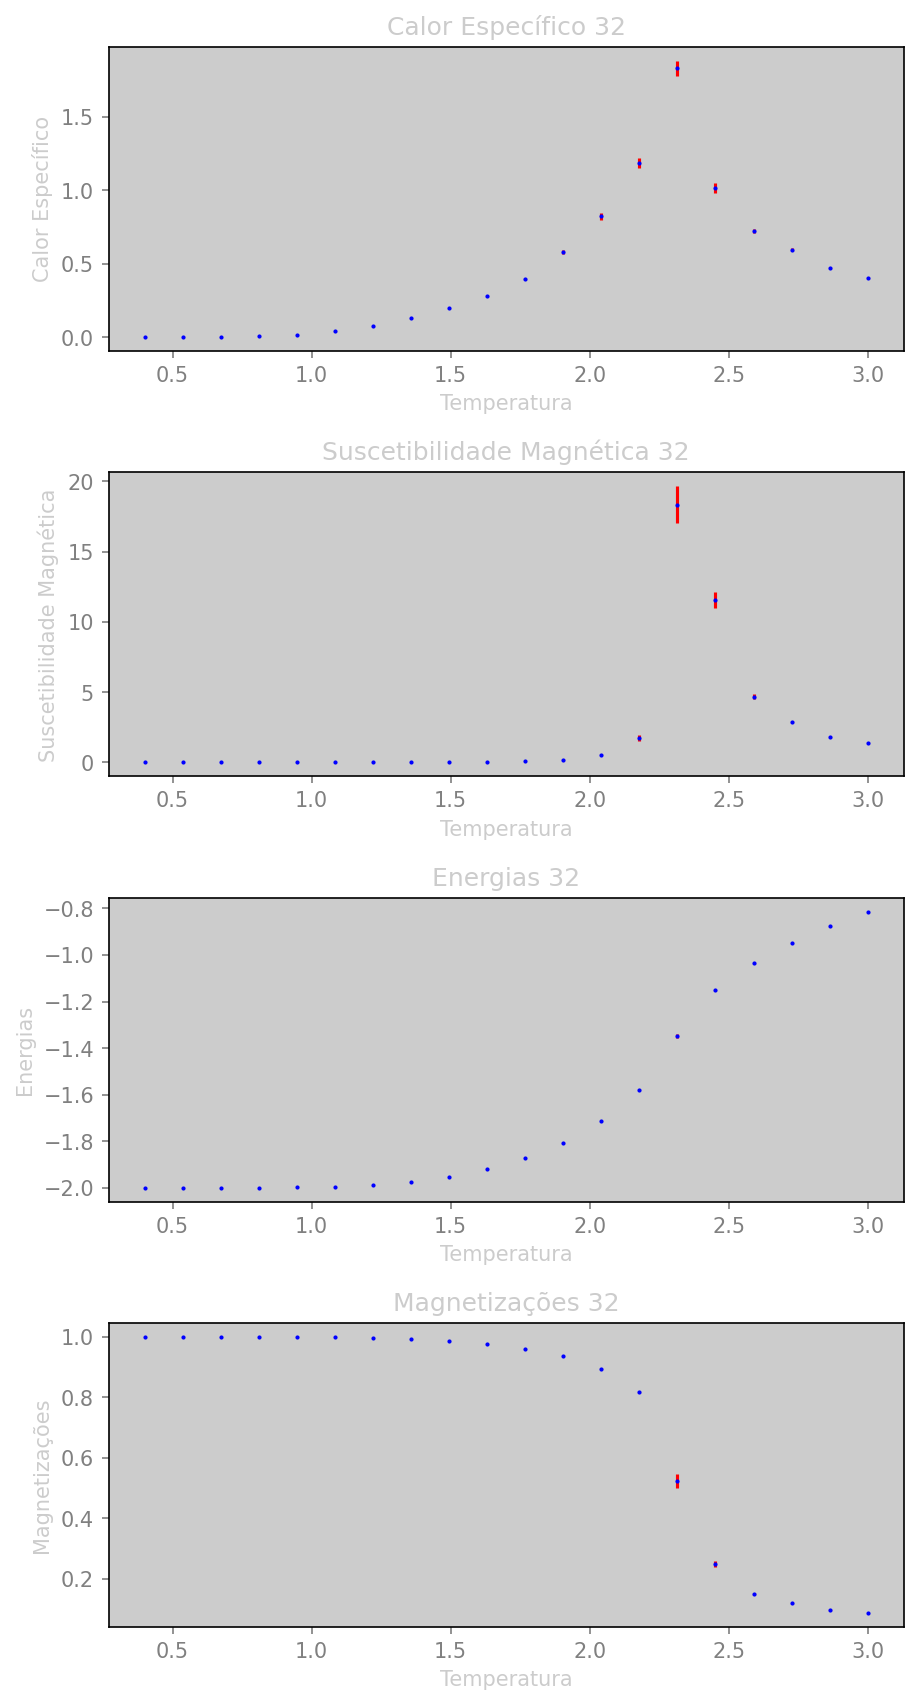

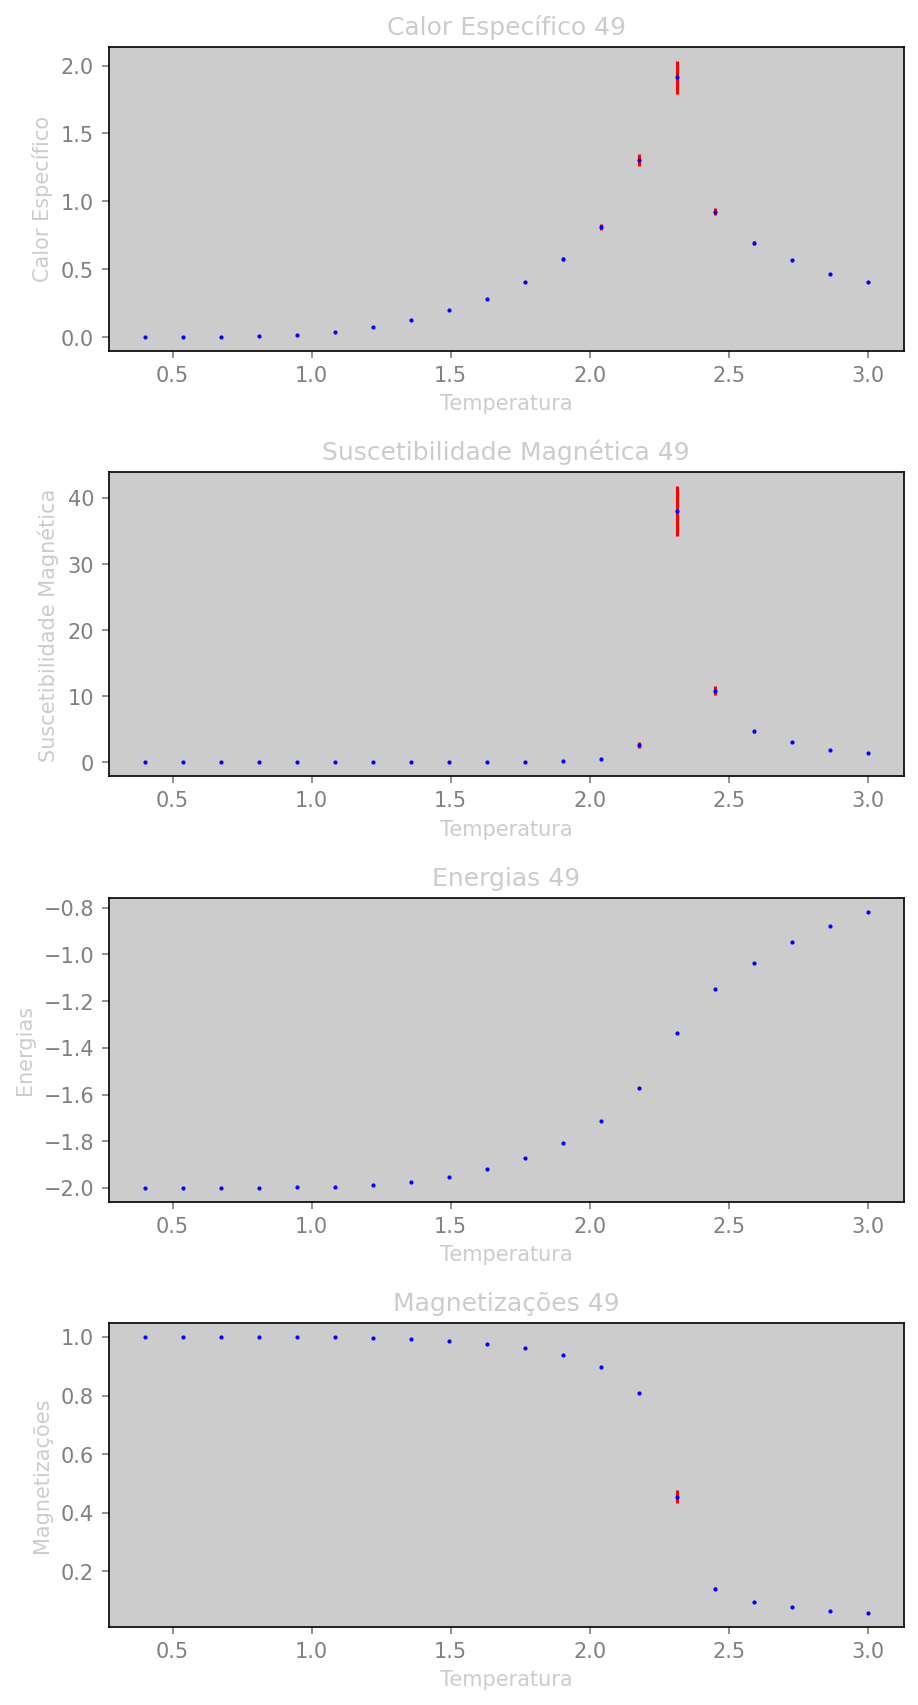

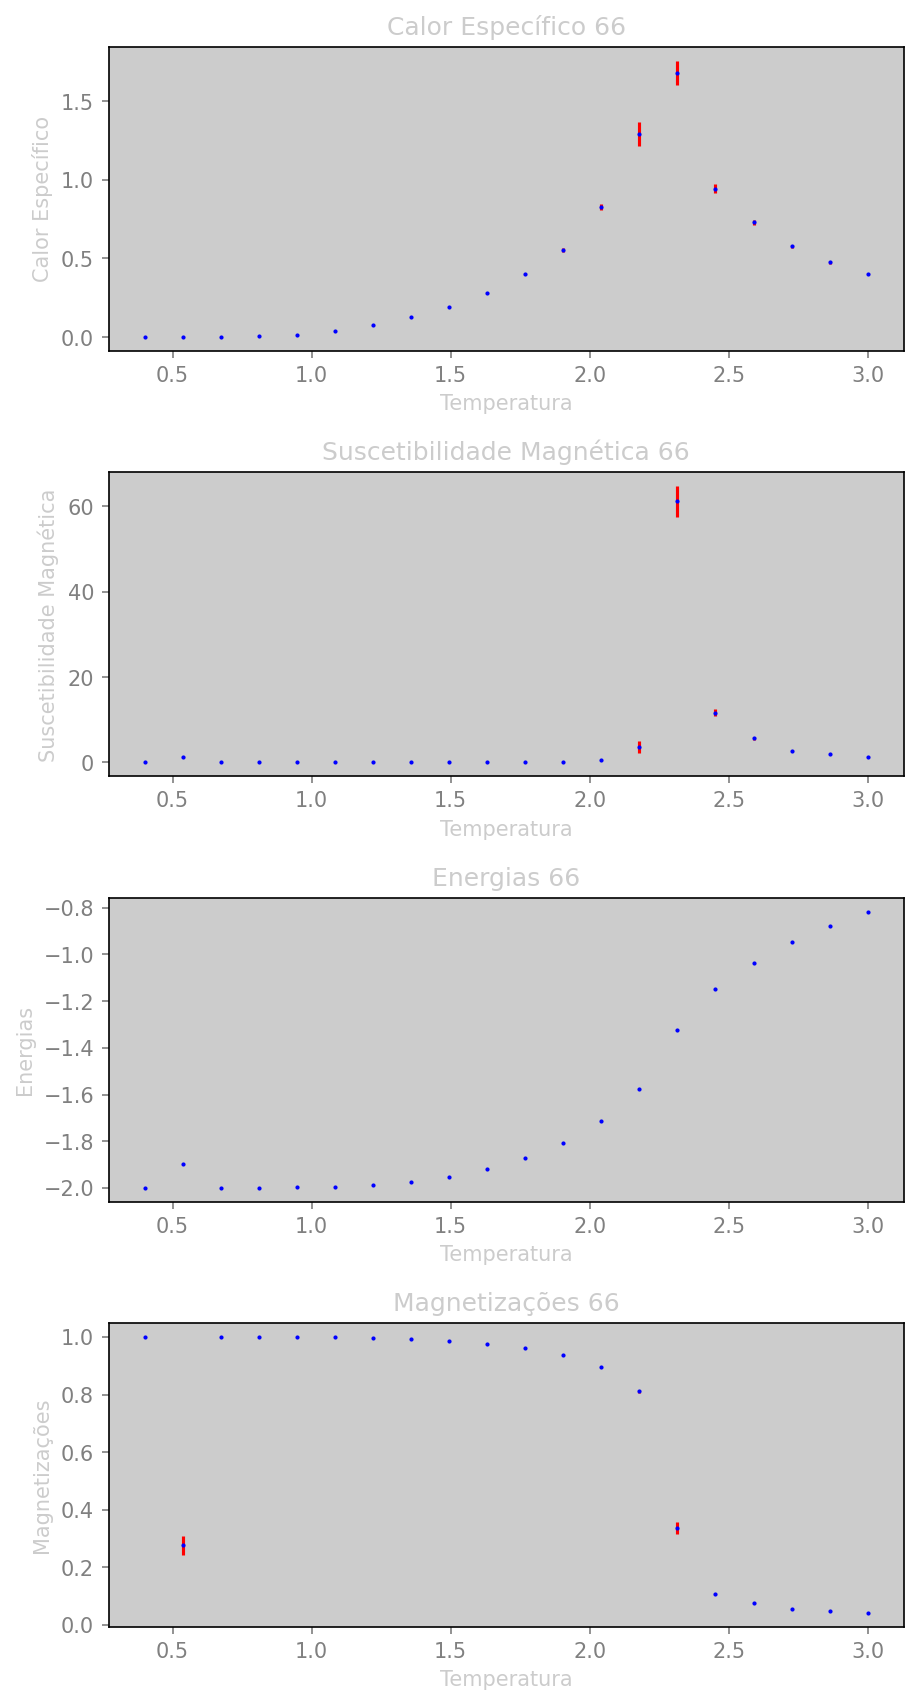

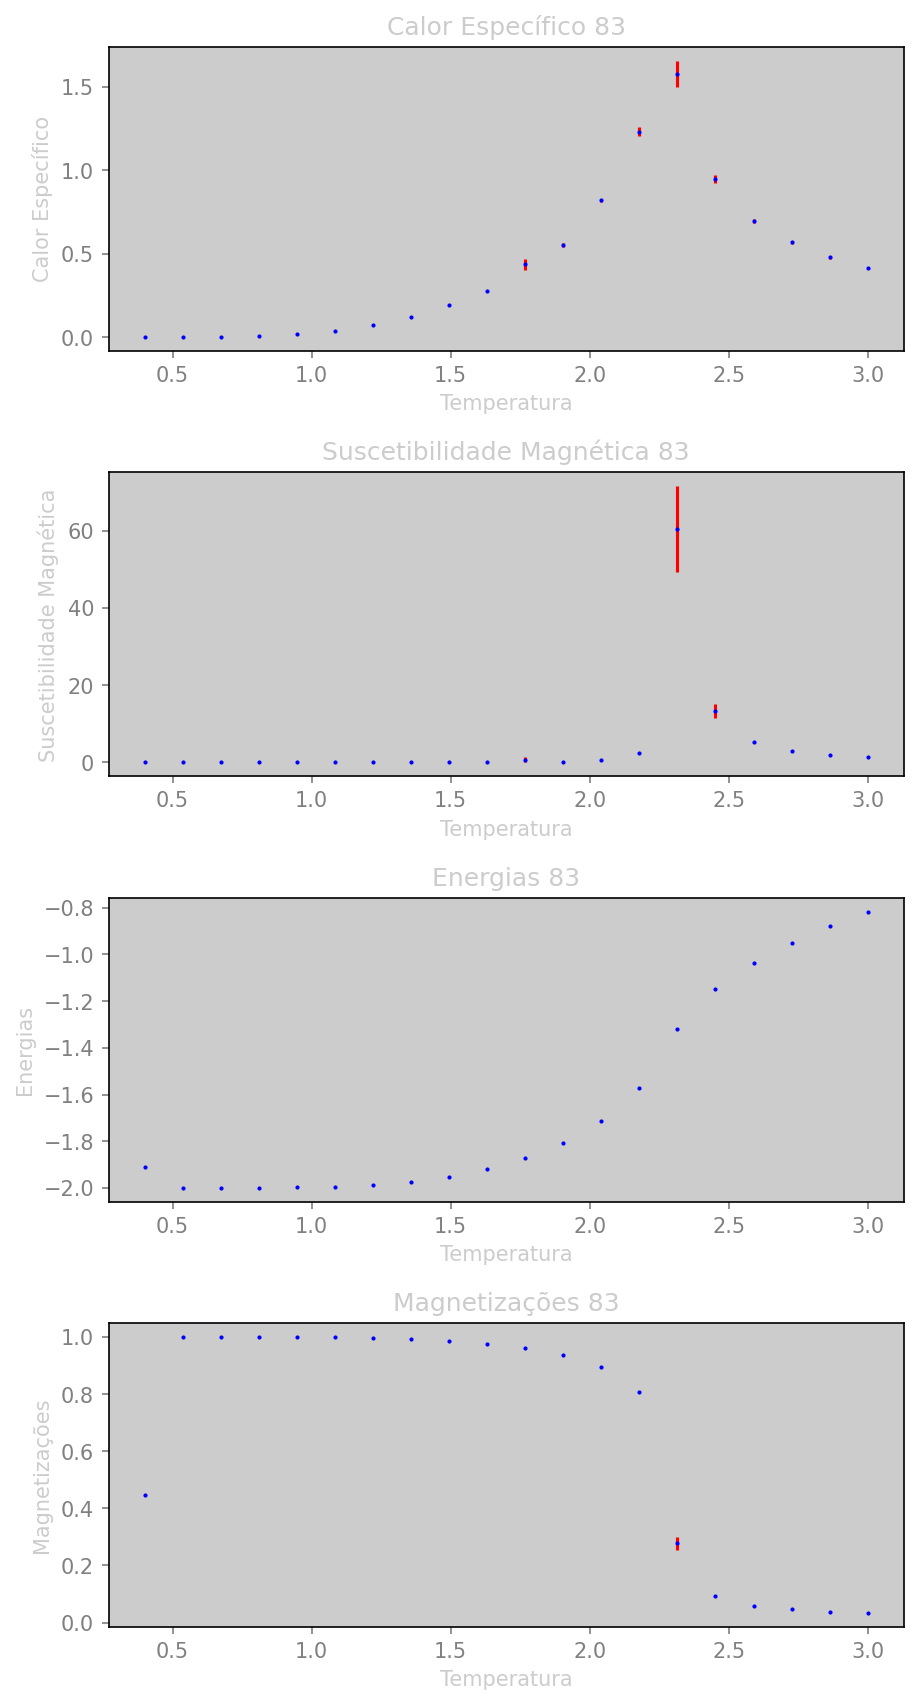

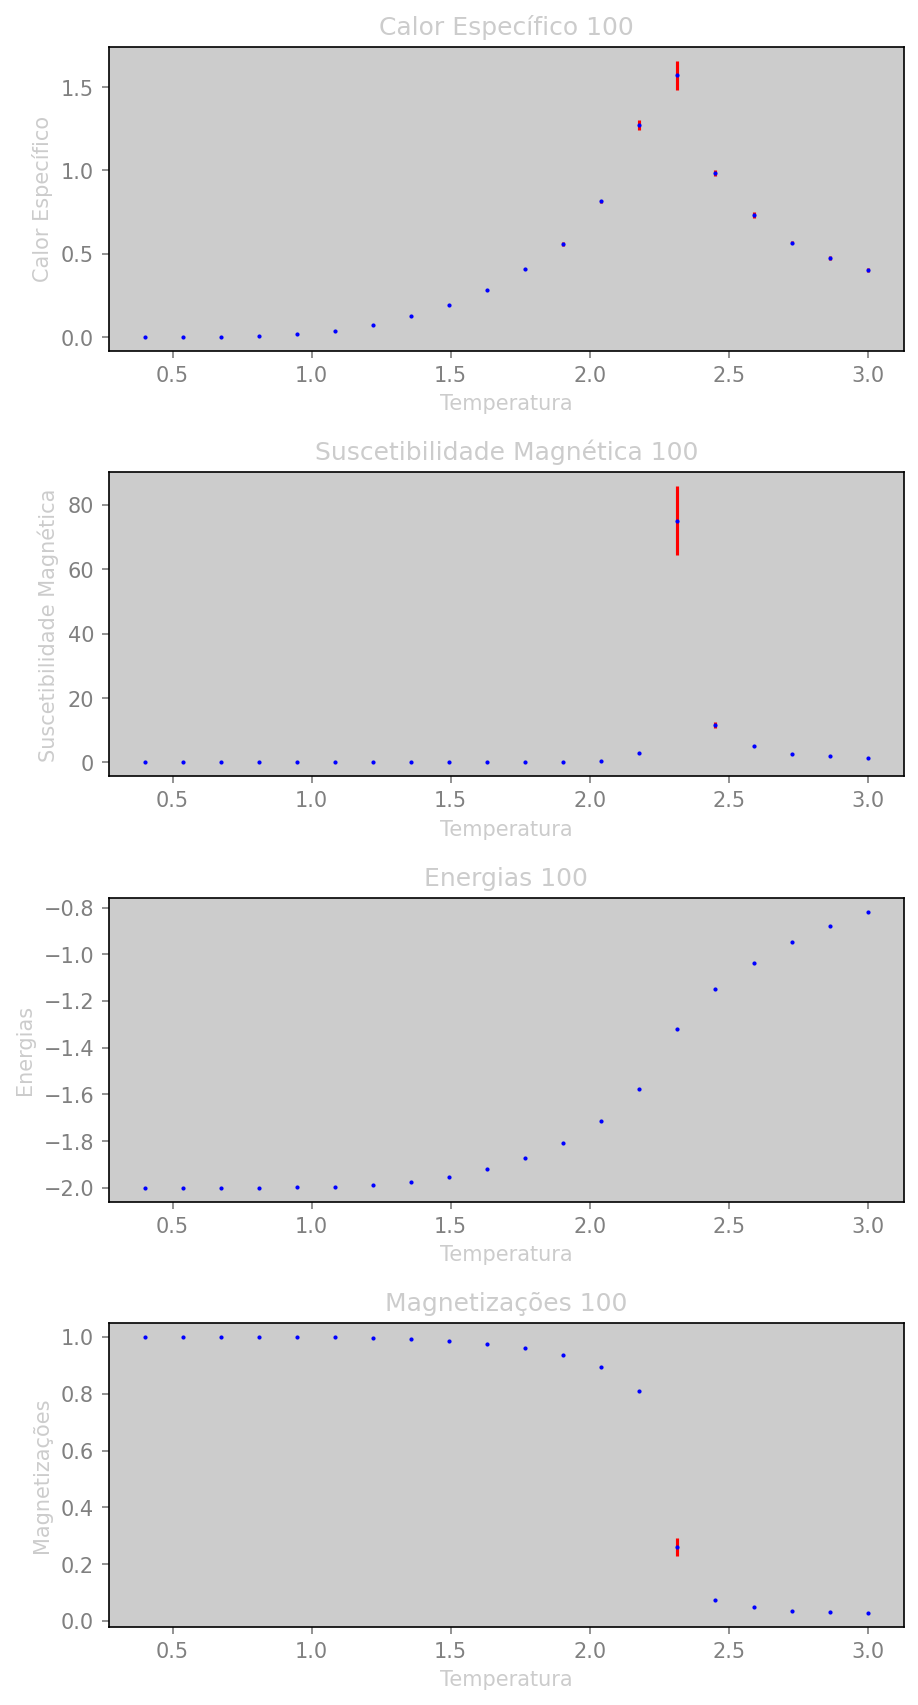

In [1]:
for comprimento in comprimentos:
    plot_por_comprimento(comprimento)